# DL training

## Setup

In [1]:
import numpy as np, pandas as pd
import os, random
from katlas.data import *
from katlas.train import *
from fastai.vision.all import *
from katlas.dnn import *

In [2]:
seed_everything()

In [3]:
def_device

'cuda'

## Data

In [4]:
df=pd.read_parquet('train/pspa_t5.parquet')

In [5]:
info=Data.get_kinase_info()

info = info[info.pseudo=='0']

info = info[info.kd_ID.notna()]

subfamily_map = info[['kd_ID','subfamily']].drop_duplicates().set_index('kd_ID')['subfamily']
family_map = info[['kd_ID','family']].drop_duplicates().set_index('kd_ID')['family']
group_map = info[['kd_ID','group']].drop_duplicates().set_index('kd_ID')['group']

pspa_info = pd.DataFrame(df.index.tolist(),columns=['kinase'])

pspa_info['subfamily'] = pspa_info.kinase.map(subfamily_map)
pspa_info['family'] = pspa_info.kinase.map(family_map)
pspa_info['group'] = pspa_info.kinase.map(group_map)

In [6]:
df=df.reset_index()

In [7]:
df.columns

Index(['index', '-5P', '-4P', '-3P', '-2P', '-1P', '0P', '1P', '2P', '3P',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1255)

In [8]:
# column name of feature and target
feat_col = df.columns[df.columns.str.startswith('T5_')]
target_col = df.columns[~df.columns.isin(feat_col)][1:]

In [9]:
feat_col

Index(['T5_0', 'T5_1', 'T5_2', 'T5_3', 'T5_4', 'T5_5', 'T5_6', 'T5_7', 'T5_8',
       'T5_9',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1024)

## Split

In [10]:
pspa_info.subfamily.value_counts()

subfamily
Eph      12
Src      11
NEK      10
CK1       7
STE11     7
         ..
ZAK       1
Sev       1
Ret       1
Musk      1
Tie       1
Name: count, Length: 149, dtype: int64

In [11]:
pspa_info.family.value_counts()

family
STE20    27
CAMKL    20
CDK      17
MAPK     12
Eph      12
         ..
STK33     1
Sev       1
Ret       1
Musk      1
Tie       1
Name: count, Length: 92, dtype: int64

In [12]:
pspa_info.group.value_counts()

group
TK          78
CAMK        57
CMGC        52
AGC         52
Other       49
STE         39
TKL         25
CK1         11
Atypical     5
Name: count, dtype: int64

In [13]:
splits = get_splits(pspa_info, stratified='subfamily',nfold=5)

split0 = splits[0]

StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
# subfamily in train set: 140
# subfamily in test set: 70


/home/sky1ove/git/KATLAS/katlas/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


## Dataset

In [14]:
# dataset
ds = GeneralDataset(df,feat_col,target_col)

In [15]:
len(ds)

368

In [16]:
dl = DataLoader(ds, batch_size=64, shuffle=True)

In [17]:
xb,yb = next(iter(dl))

xb.shape,yb.shape

(torch.Size([64, 1024]), torch.Size([64, 23, 10]))

## Model

In [18]:
n_feature = len(feat_col)
n_target = len(target_col)

In [19]:

# def get_mlp(): return PSSM_model(n_feature,n_target,model='MLP')

def get_cnn(): return PSSM_model(n_feature,n_target,model='CNN')

In [20]:
model = get_cnn()

In [21]:
logits= model(xb)

In [22]:
logits.shape

torch.Size([64, 23, 10])

## Loss

In [23]:
CE(logits,yb)

tensor(3.3157, grad_fn=<MeanBackward0>)

## Metrics

In [24]:
KLD(logits,yb)

tensor(0.5744, grad_fn=<MeanBackward0>)

In [25]:
JSD(logits,yb)

tensor(0.1175, grad_fn=<MeanBackward0>)

## CV train
> cross-validation

In [26]:
oof = train_dl_cv(df,feat_col,target_col,
                  splits = splits,
                  model_func = get_cnn,
                  n_epoch=20,lr=3e-3,save='cnn_pspa')

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.217853,3.129733,0.383709,0.082217,00:03
1,3.109176,3.025892,0.279868,0.065816,00:00
2,3.033263,3.009331,0.263307,0.049194,00:00
3,2.995653,2.975954,0.229930,0.047896,00:00
4,2.974805,2.959821,0.213797,0.044693,00:00
5,2.954576,2.876532,0.130508,0.031249,00:00
6,2.931996,2.841035,0.095011,0.022667,00:00
7,2.912550,2.826984,0.080960,0.019480,00:00
8,2.894981,2.812936,0.066912,0.016306,00:00
9,2.878739,2.808757,0.062733,0.015131,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.227988,3.122205,0.371023,0.080161,00:00
1,3.114955,3.006885,0.255704,0.060191,00:00
2,3.033851,3.014883,0.263702,0.045376,00:00
3,2.991390,3.081414,0.330233,0.054259,00:00
4,2.971378,3.100762,0.349581,0.050193,00:00
5,2.949943,3.000693,0.249511,0.043282,00:00
6,2.928316,2.853219,0.102037,0.024705,00:00
7,2.908070,2.822800,0.071619,0.017401,00:00
8,2.889901,2.814464,0.063283,0.015329,00:00
9,2.874873,2.809858,0.058676,0.014038,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.207634,3.126234,0.375105,0.080694,00:00
1,3.099358,3.000446,0.249318,0.058063,00:00
2,3.024896,3.021820,0.270691,0.047111,00:00
3,2.983423,3.028692,0.277563,0.045973,00:00
4,2.961031,3.048359,0.297231,0.046780,00:00
5,2.939984,2.913493,0.162364,0.035342,00:00
6,2.921817,2.849592,0.098463,0.023461,00:00
7,2.905294,2.822308,0.071179,0.017384,00:00
8,2.888041,2.810550,0.059422,0.014578,00:00
9,2.872705,2.803184,0.052055,0.012731,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.215657,3.133509,0.386007,0.082119,00:00
1,3.113026,3.027662,0.280160,0.065950,00:00
2,3.036628,3.029867,0.282365,0.047388,00:00
3,2.991904,3.075051,0.327550,0.052629,00:00
4,2.965200,2.991984,0.244482,0.045841,00:00
5,2.943707,2.941938,0.194437,0.040855,00:00
6,2.924345,2.852011,0.104509,0.025841,00:00
7,2.905029,2.829586,0.082084,0.019922,00:00
8,2.888455,2.810707,0.063206,0.015449,00:00
9,2.873662,2.802326,0.054824,0.013523,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.212260,3.117836,0.374646,0.081583,00:00
1,3.107344,2.999742,0.256551,0.059491,00:00
2,3.035820,3.040172,0.296981,0.048000,00:00
3,2.991336,3.117648,0.374457,0.053892,00:00
4,2.965030,3.015245,0.272055,0.046076,00:00
5,2.945225,2.915272,0.172081,0.037266,00:00
6,2.925535,2.850654,0.107463,0.026040,00:00
7,2.906100,2.818401,0.075210,0.018124,00:00
8,2.889269,2.808335,0.065145,0.015896,00:00
9,2.874656,2.802177,0.058986,0.014392,00:00


In [27]:
oof.to_parquet('raw/oof_pspa.parquet')

## Score

In [28]:
from katlas.clustering import *

from functools import partial

In [29]:
def score_df(target,pred,func):
    distance = [func(target.loc[i],pred.loc[i,target.columns]) for i in target.index]
    return pd.Series(distance,index=target.index)

In [30]:
jsd_df = partial(score_df,func=js_divergence_flat)
kld_df = partial(score_df,func=kl_divergence_flat)

In [31]:
target=df[target_col].copy()

In [32]:
pspa_info['group_split'] = oof.nfold

In [33]:
pspa_info['group_jsd'] =jsd_df(target,oof)

In [34]:
from katlas.plot import *

In [35]:
set_sns()

Text(0.5, 1.0, 'Stratified split in kinase subfamily')

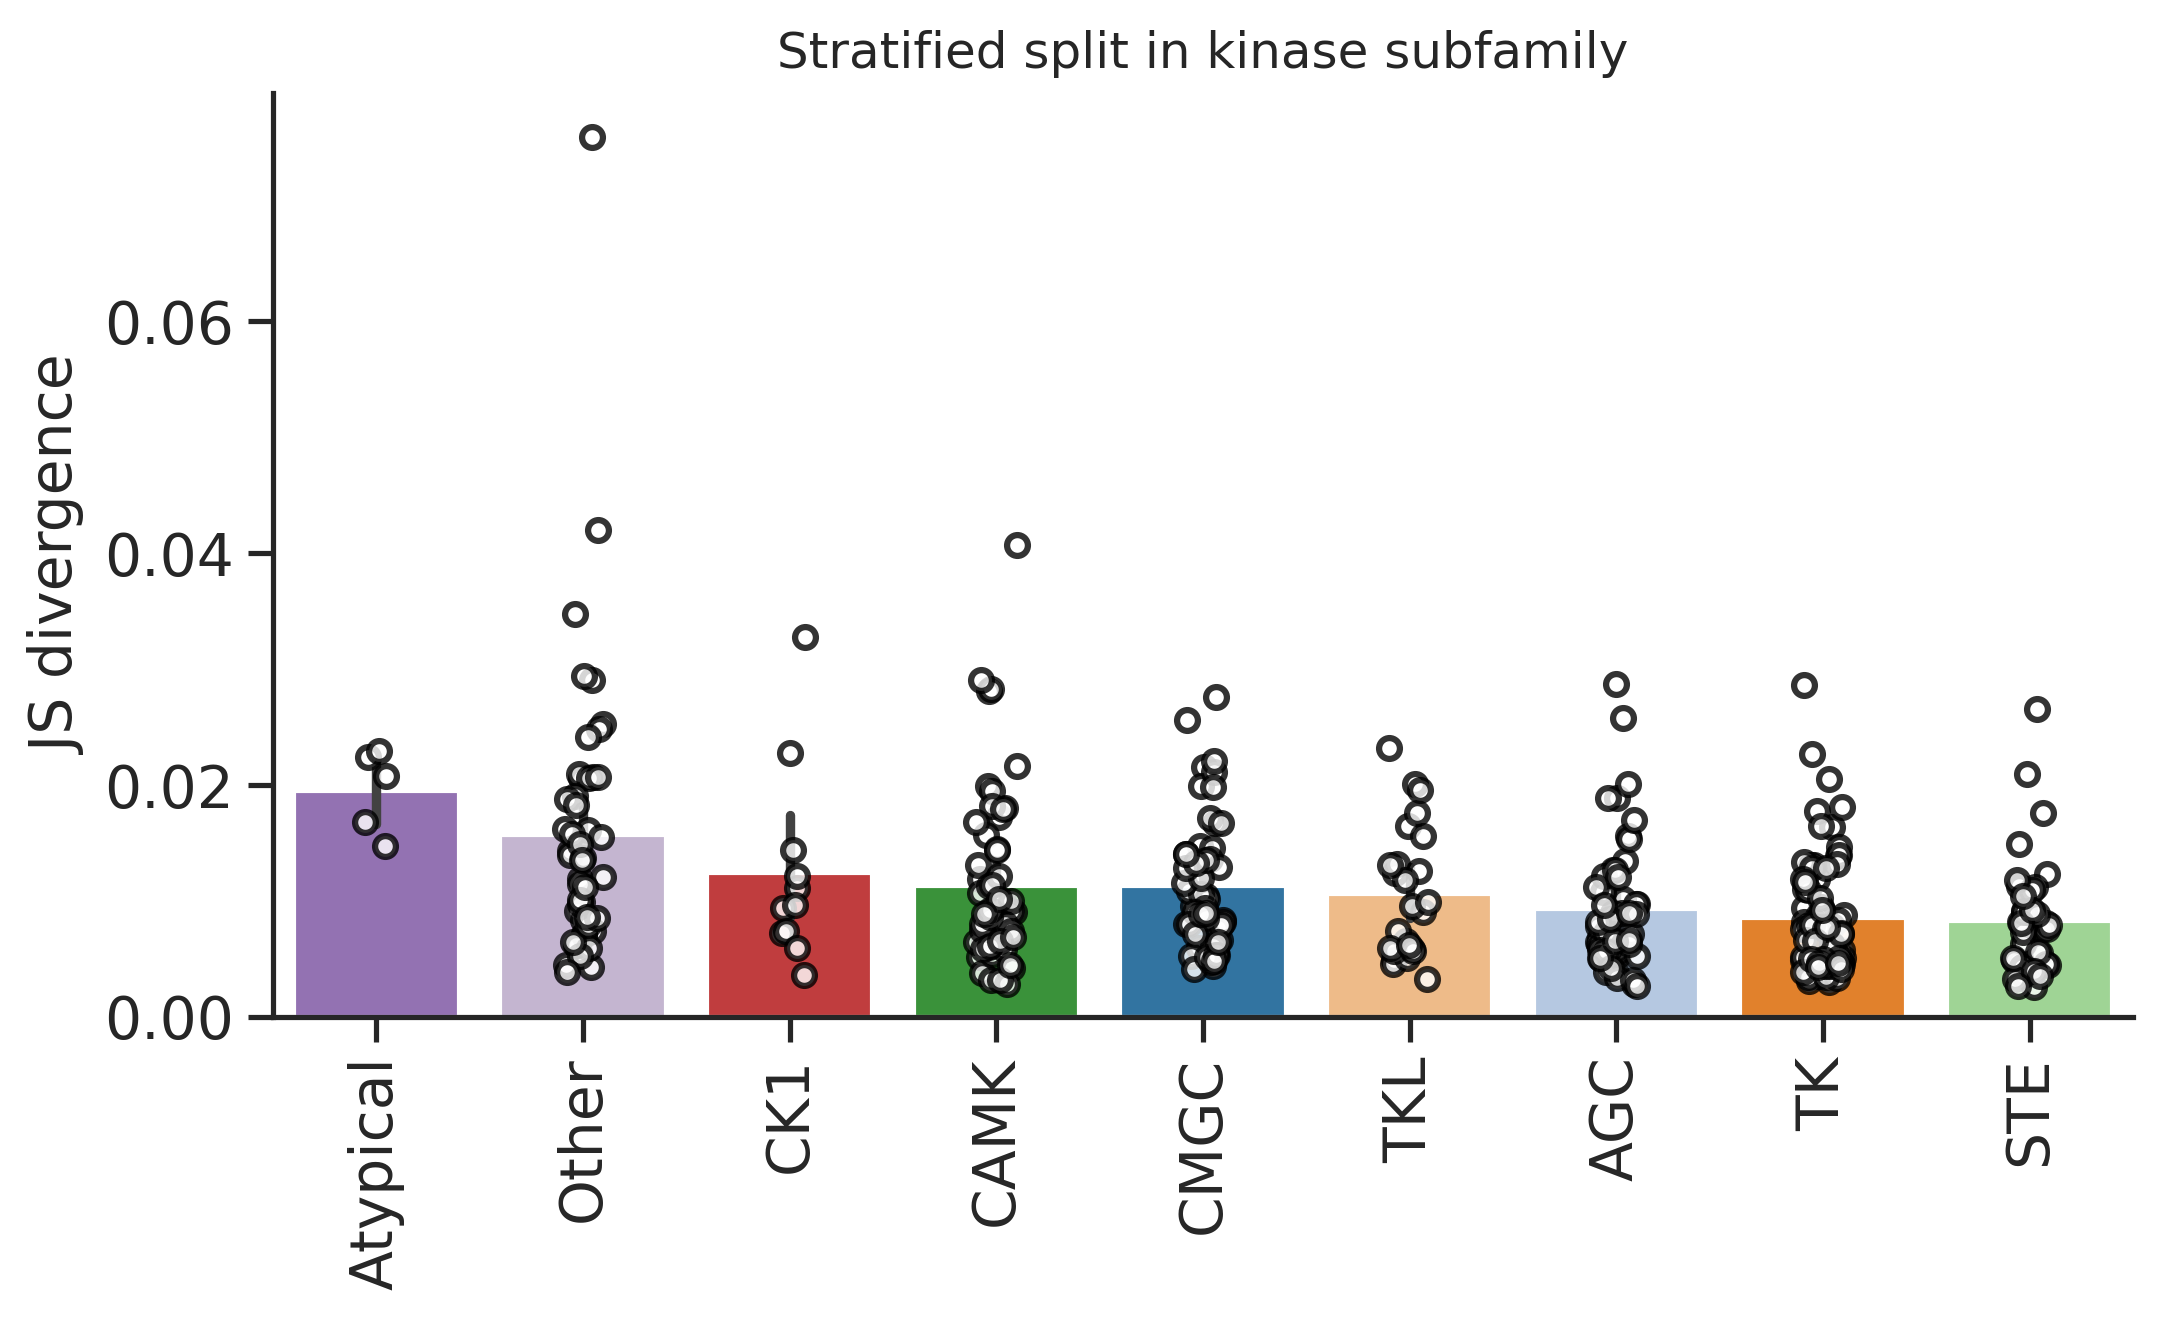

In [36]:
plot_bar(pspa_info,'group_jsd',group='group',palette=group_color,figsize=(8,4))
plt.ylabel('JS divergence')
plt.title('Stratified split in kinase subfamily')

In [37]:
group_color = pd.DataFrame(group_color).T

In [38]:
sty_color

{'S': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'T': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'Y': (1.0, 0.4980392156862745, 0.054901960784313725)}

In [39]:
group_color = group_color.reset_index(names='modi_group')

In [40]:
info = Data.get_kinase_info()

In [41]:
subfamily_color = info[['modi_group','subfamily']].merge(group_color).drop(columns=['modi_group']).set_index('subfamily')

In [42]:
subfamily_color = subfamily_color.apply(tuple, axis=1).to_dict()

Text(0, 0.5, 'JS divergence')

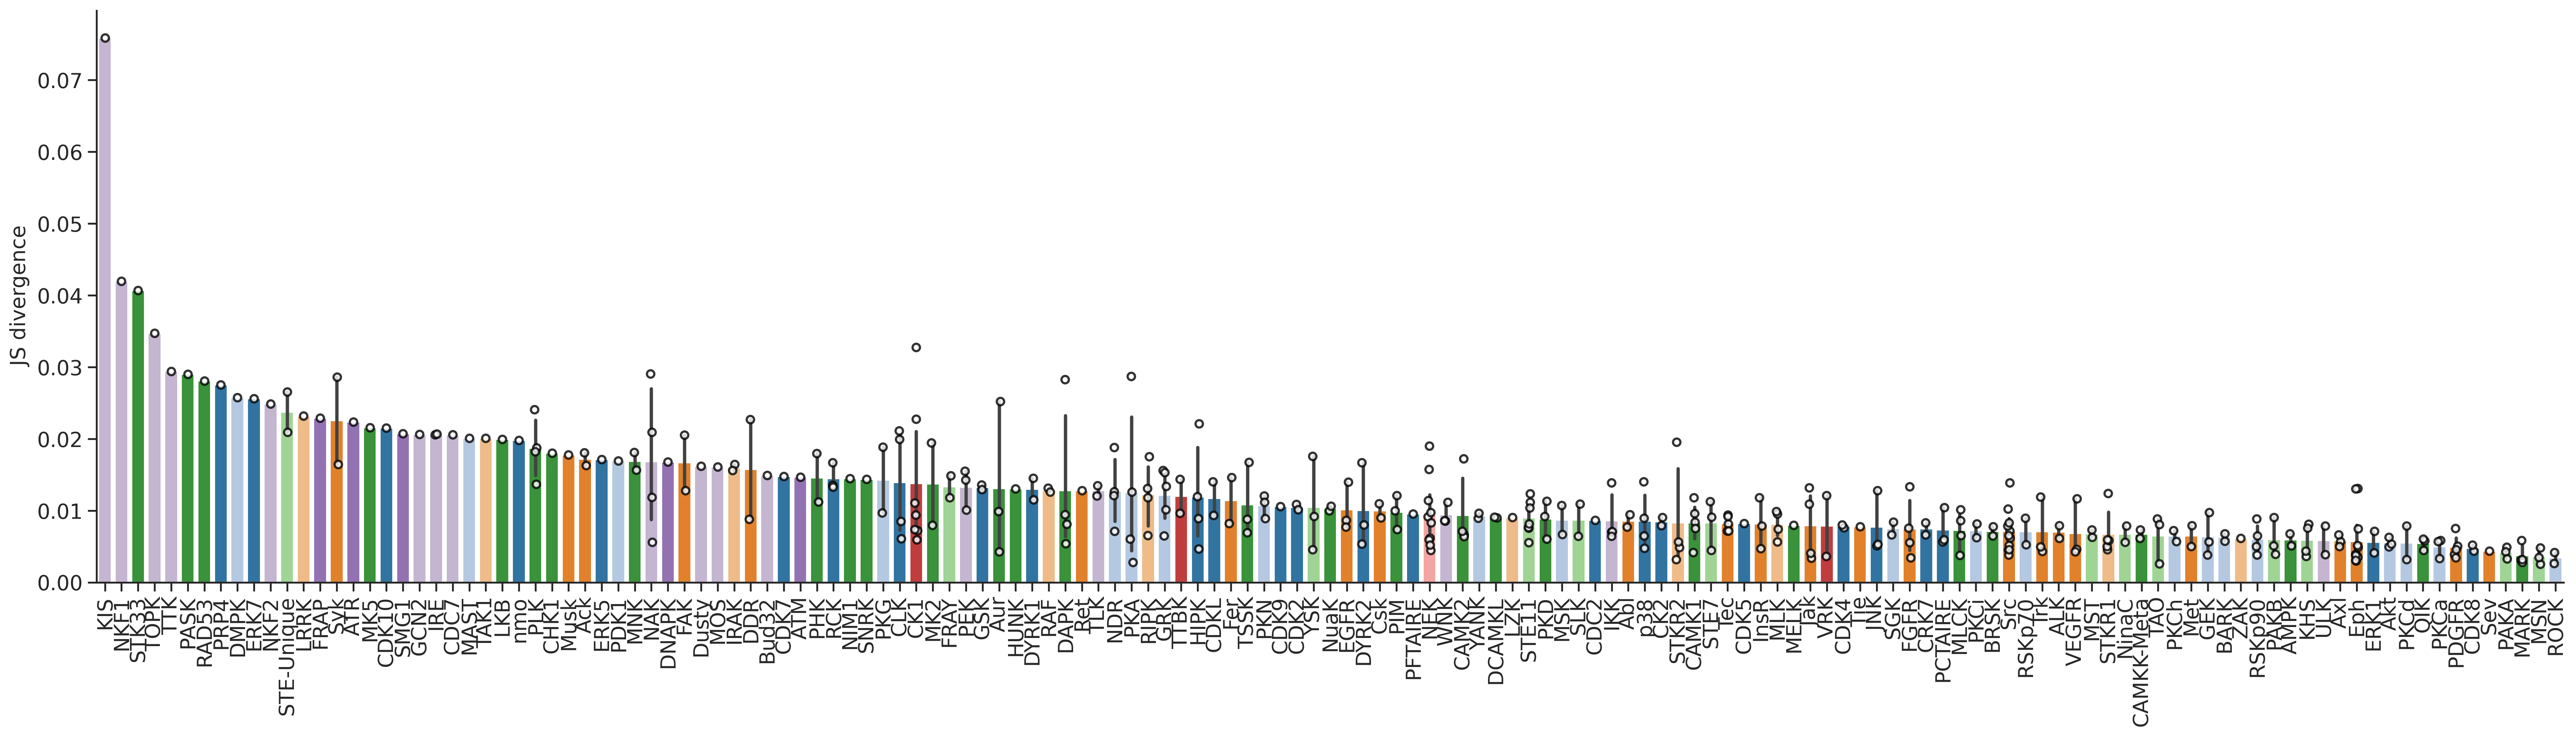

In [43]:
plot_bar(pspa_info,'group_jsd',group='subfamily',palette = subfamily_color, figsize=(30,7))
plt.ylabel('JS divergence')
# plt.title('Stratified split in kinase subfamily')

In [44]:
pspa_info.sort_values('group_jsd')

,kinase,subfamily,family,group,group_split,group_jsd
104,O95819_M4K4_HUMAN_KD1,MSN,STE20,STE,2,0.002563
265,Q9UL54_TAOK2_HUMAN_KD1,TAO,STE20,STE,2,0.002613
246,Q13464_ROCK1_HUMAN_KD1,ROCK,DMPK,AGC,0,0.002652
137,Q7KZI7_MARK2_HUMAN_KD1,MARK,CAMKL,CAMK,1,0.002785
212,P17612_KAPCA_HUMAN_KD1,PKA,PKA,AGC,2,0.002793
...,...,...,...,...,...,...
62,Q9HCP0_KC1G1_HUMAN_KD1,CK1,CK1,CK1,0,0.032721
203,Q96KB5_TOPK_HUMAN_KD1,TOPK,TOPK,Other,2,0.034704
261,Q9BYT3_STK33_HUMAN_KD1,STK33,STK33,CAMK,0,0.040650
251,Q52WX2_SBK1_HUMAN_KD1,NKF1,NKF1,Other,2,0.041941


In [45]:
from katlas.pssm import *

In [46]:
def plot_one_pssm(target,pred,idx):
    target_pssm = recover_pssm(target.loc[idx])
    pred_pssm = recover_pssm(pred.loc[idx,target.columns])
    plot_heatmap(target_pssm)
    plot_heatmap(pred_pssm)

In [47]:
set_sns(50)

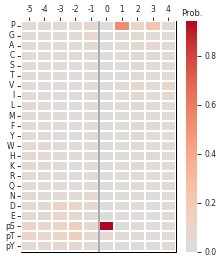

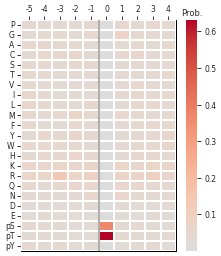

In [48]:
plot_one_pssm(target,oof,125)